In [1]:
import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/usr/bin/python


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = params.ticker
folder = "Intraday stocks" 

month_to_plot = '2024-05' # just used if date_to_check = None

date_to_check = params.date_to_check 

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


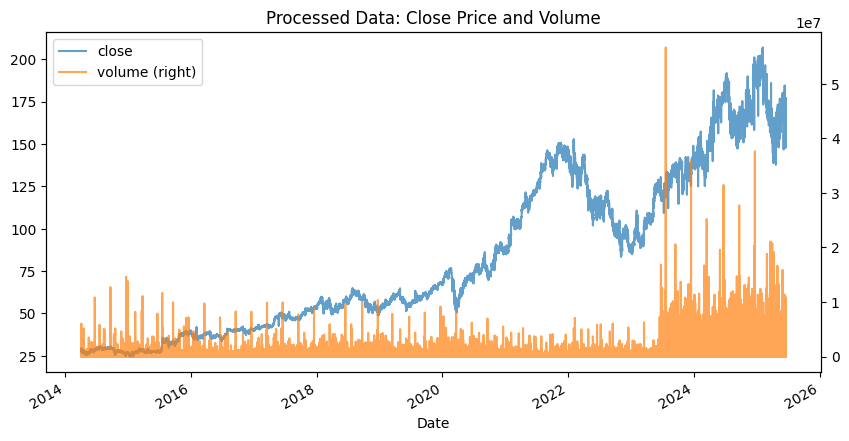

,open,high,low,close,volume,ask,bid
datetime,,,,,,,
2014-04-03 10:42:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 10:43:00,28.6500,28.6500,28.6500,28.6500,2000.0,28.658595,28.641405
2014-04-03 11:04:00,28.6500,28.6500,28.6500,28.6500,11220.0,28.658595,28.641405
2014-04-03 11:05:00,28.6500,28.6500,28.6500,28.6500,4620.0,28.658595,28.641405
2014-04-03 11:34:00,28.5005,28.5005,28.5005,28.5005,3460.0,28.509050,28.491950
...,...,...,...,...,...,...,...
2025-06-18 23:55:00,173.9000,173.9445,173.8670,173.8681,3136.0,173.920300,173.815900
2025-06-18 23:56:00,173.8200,173.9500,173.7900,173.9000,183.0,173.952200,173.847800
2025-06-18 23:57:00,173.9500,173.9500,173.8600,173.8601,240.0,173.912300,173.807900


In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = trades.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=params.bidasktoclose_spread,
                                vol_fact=1)

df

In [4]:
def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    try:
        day_df_prep = trades.prepare_interpolate_data( 
            df=day_df,
            regular_start_shifted=params.regular_start_shifted,
            regular_start=params.regular_start,
            regular_end=params.regular_end
        )
    except ValueError as ve:
        if "window 0" in str(ve):
            print(" warning: smoothing window=0; skipping smoothing.")
        else:
            raise

    result = trades.run_trading_pipeline(day_df_prep, 
                                         col_signal='signal_smooth',
                                         col_action='signal_action',
                                         day_to_check=day_str)
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal_scaled',
        col_signal2='signal_smooth',
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [5]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume", "bid","ask",
            "StrategyEarning","EarningDiff", "signal_scaled", "signal_smooth", "signal_action"
        ]

    if date_to_check:
        if len(date_to_check) == 7:
            # -------------------------------------------------------------------------
            # # Month mode: 'YYYY-MM'
            # -------------------------------------------------------------------------
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )

            performance_list = []
            daily_frames     = []
            
            for d in sorted(days.astype(str)):
                res = process_single_day(d, buy_threshold)
                if res is None:
                    continue
    
                df_day, perf_day = res
                daily_frames.append(df_day)       # collect the day’s DF
                performance_list.append(perf_day) # collect its stats
    
            if not daily_frames:
                print("No valid days in this month.")
                return
    
            # build the month‐DF from exactly those df_day’s
            df_month = pd.concat(daily_frames).sort_index()
            # print monthly performance summary
            monthly_summary = plots.aggregate_performance(performance_list, df_month)
            pprint(monthly_summary)

            return df_month
            
        else:
            # -------------------------------------------------------------------------
            # Single-day mode: 'YYYY-MM-DD'
            # -------------------------------------------------------------------------
            return process_single_day(date_to_check, buy_threshold)

    # -------------------------------------------------------------------------
    # Full mode: Processing all days and saving dataframe
    # -------------------------------------------------------------------------
    print(f"\nFull-run mode: started at {datetime.now():%H:%M:%S}")
        
    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(
        df=df,
        regular_start_shifted=params.regular_start_shifted,
        regular_start=params.regular_start,
        regular_end=params.regular_end
    )
      
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df_prep,
        col_signal='signal_smooth',
        col_action='signal_action',
        day_to_check=None
    )

    print("\n Step C: merging, concatenating all days, and calculating test performances …")
    daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all          = pd.concat(daily_frames).sort_index()
    performance_all = [res[2] for res in full_sim_results.values()]
    days_all = df_all.index.normalize().unique()

    cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
    df_test = df_all[ df_all.index.normalize().isin(test_days) ]
    performance_test = [perf
                        for day, (_,_,perf) in full_sim_results.items()
                        if pd.Timestamp(day).normalize() in test_days]
    test_summary = plots.aggregate_performance(performance_test, df_test)
    pprint(test_summary)

    print("\n Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_final.csv"
    df_all.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return df_all


In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_man, 
                        max_down_prop=params.max_down_prop_man, 
                        gain_tightening_factor=params.gain_tightening_factor_man,
                        smooth_win_sig=params.smooth_win_sig_man, 
                        pre_entry_decay=params.pre_entry_decay_man, 
                        buy_threshold=params.buy_threshold_man, 
                        trailing_stop_thresh=params.trailing_stop_thresh_man,
                        merging_retracement_thr=params.merging_retracement_thr_man, 
                        merging_time_gap_thr=params.merging_time_gap_thr_man,
                        date_to_check=params.date_to_check
                        )

df_fin



Full-run mode: started at 14:41:12
 Step A: smoothing & DST adjust …

 Step B: running trading pipeline on full dataset …
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …

 Step C: merging, concatenating all days, and calculating test performances …

=== Overall Summary (2023-10-12 → 2025-06-18) ===
Start date price: 2023-10-12 = 140.4855
  End date price:  2025-06-18 = 173.5576
One-time buy&hold gain: 33.072

{'Buy & Hold – each day ($)': -77.566,
 'Strategy Return ($)': 472.82,
 'Trades Returns ($)': '1162 trades'}

 Step D: saving CSV …
Saved to dfs training/GOOGL_final.csv at 14:42:59


,open,high,low,close,volume,bid,ask,StrategyEarning,EarningDiff,signal_scaled,signal_smooth,signal_action
2014-04-03 10:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.398980,0.401385,0
2014-04-03 10:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.400179,0.401989,0
2014-04-03 10:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.401381,0.402595,0
2014-04-03 10:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.402587,0.403201,0
2014-04-03 10:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.641405,28.658595,0.0,0.000,0.403797,0.403809,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.512900,173.617100,-1.4,1.310,0.000000,0.000000,0
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.328000,173.432000,-1.4,1.495,0.000000,0.000000,0
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.258000,173.362000,-1.4,1.565,0.000000,0.000000,0
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.228000,173.332000,-1.4,1.595,0.000000,0.000000,0


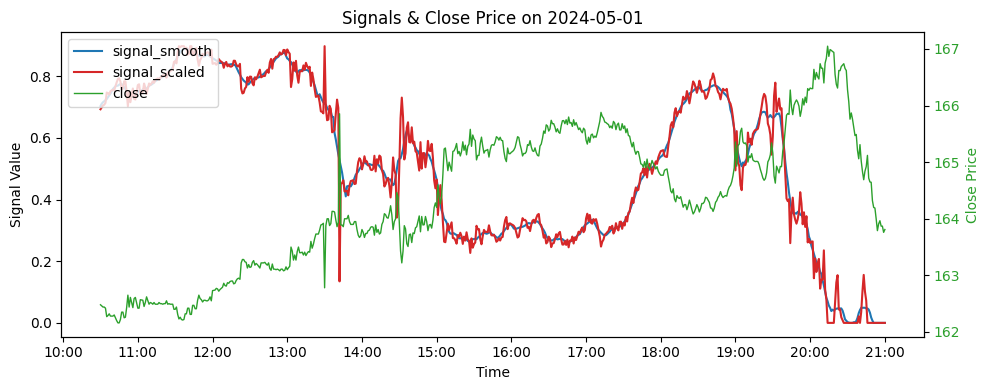

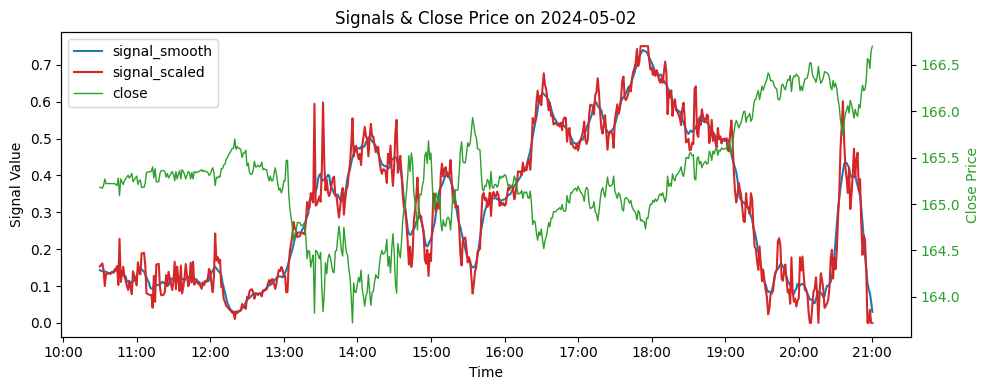

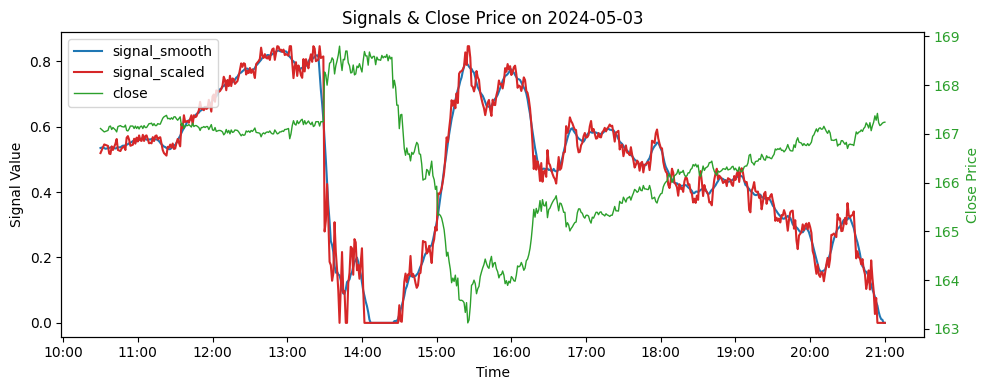

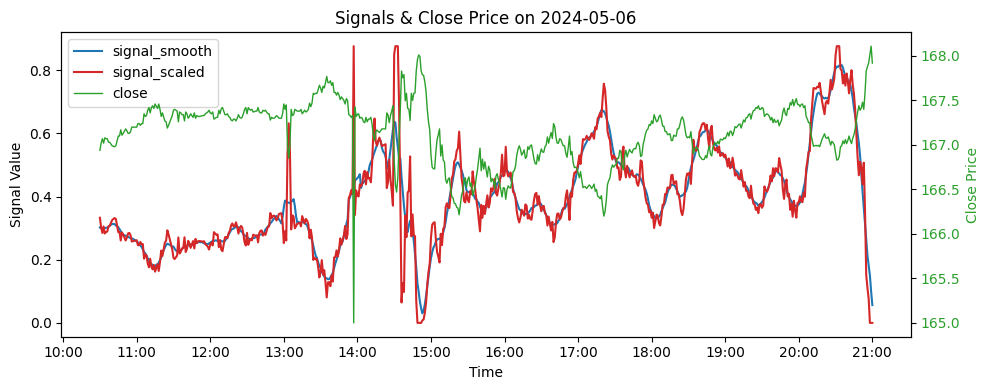

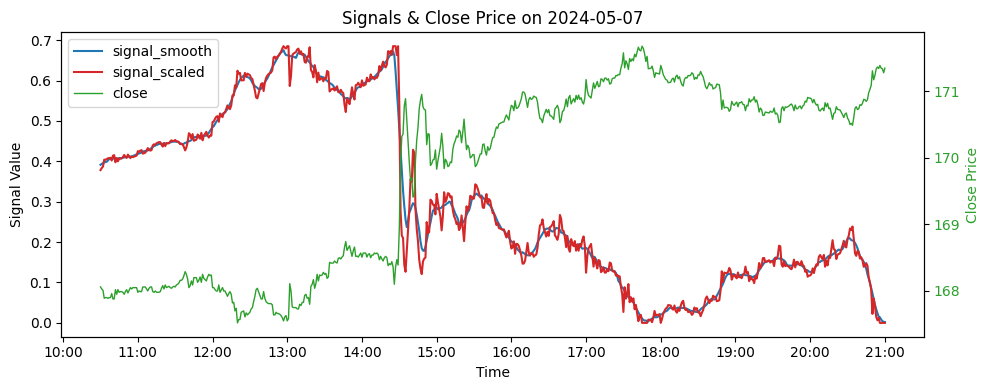

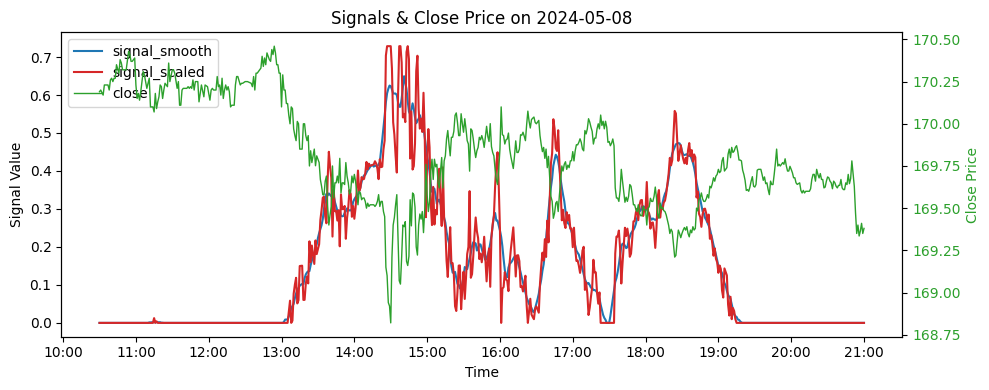

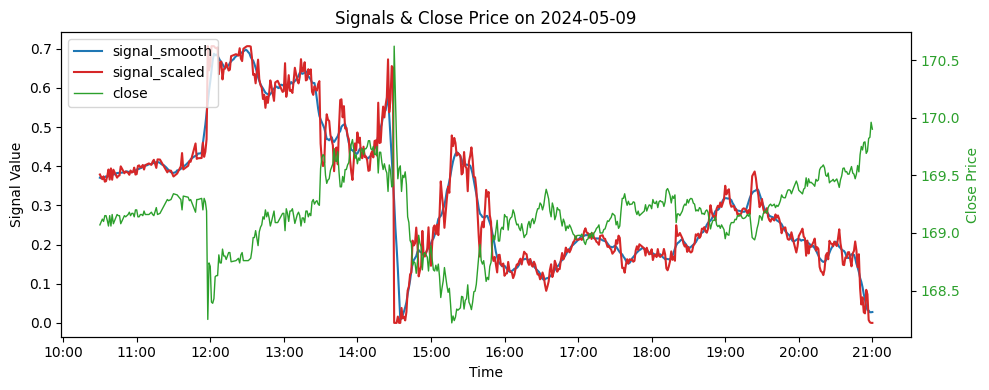

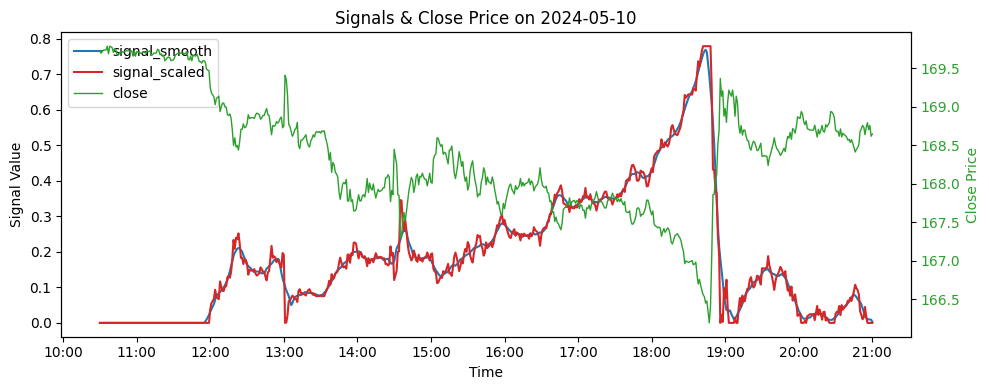

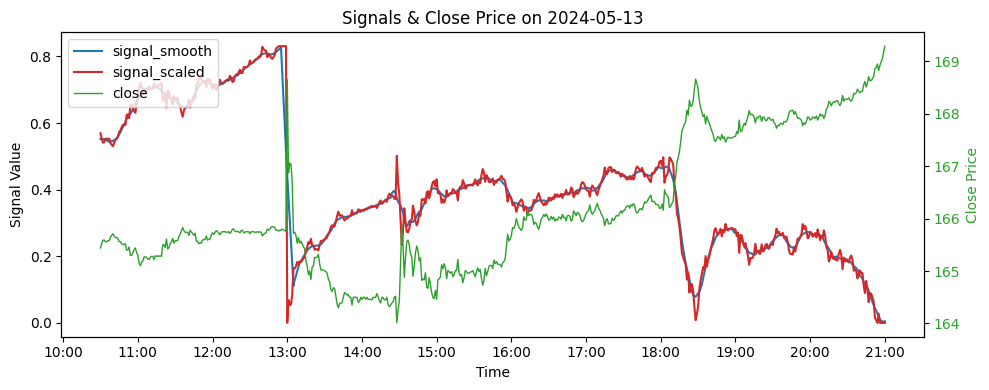

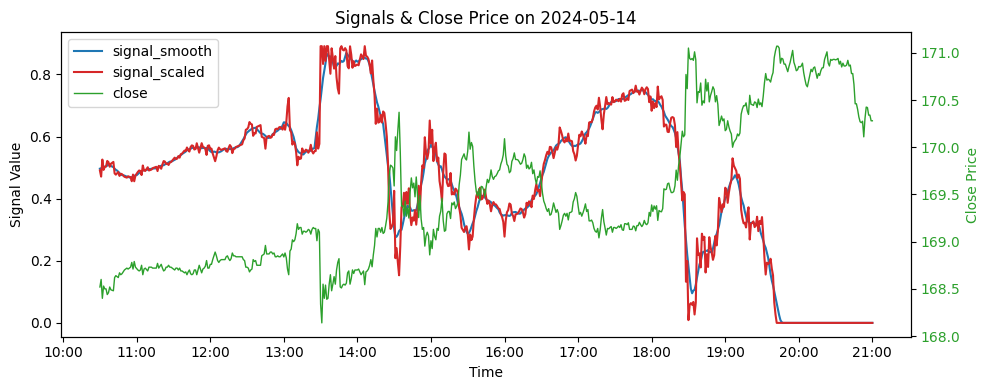

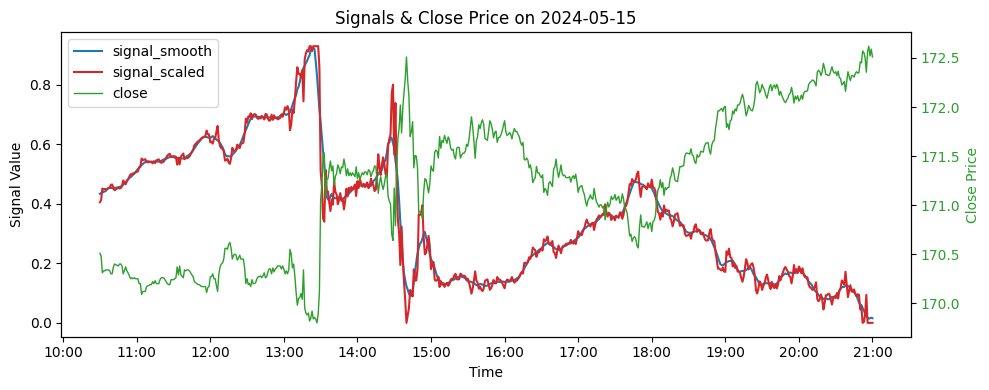

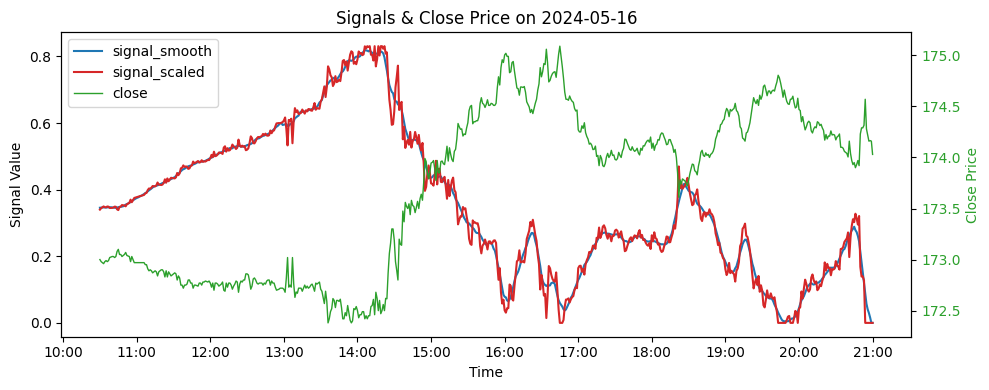

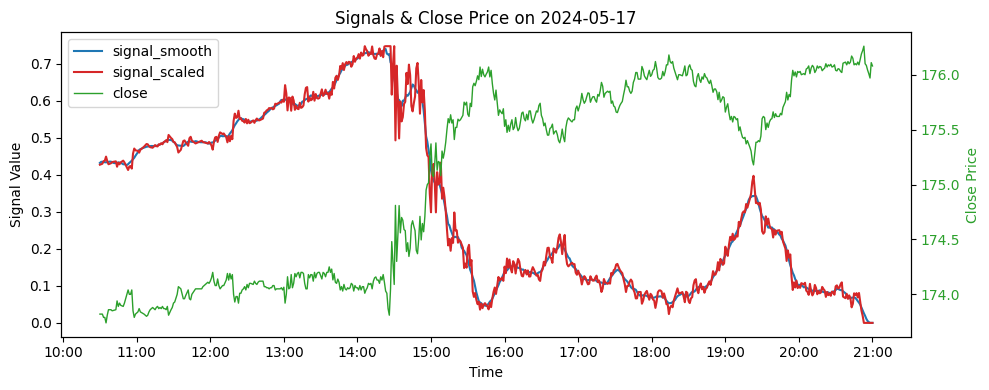

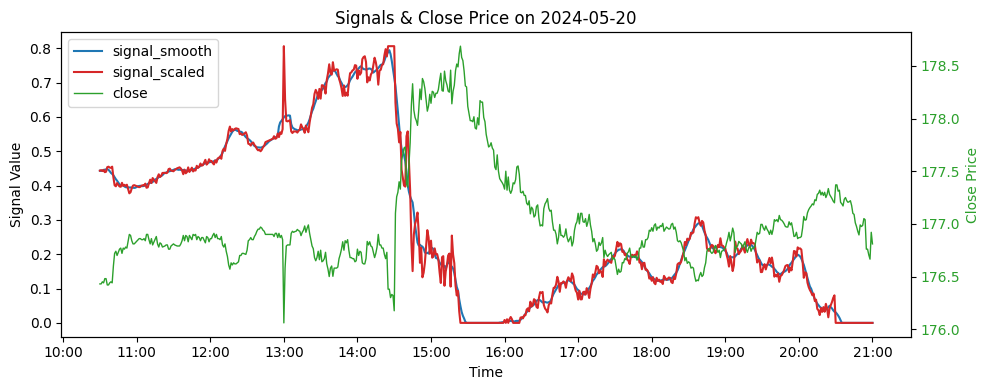

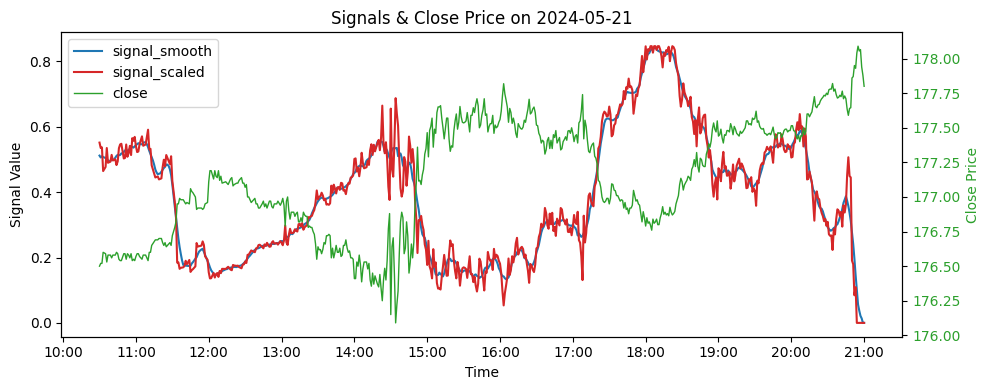

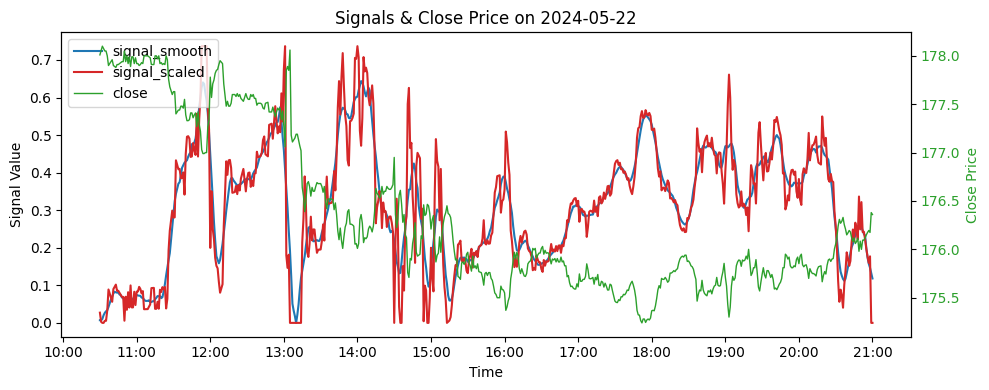

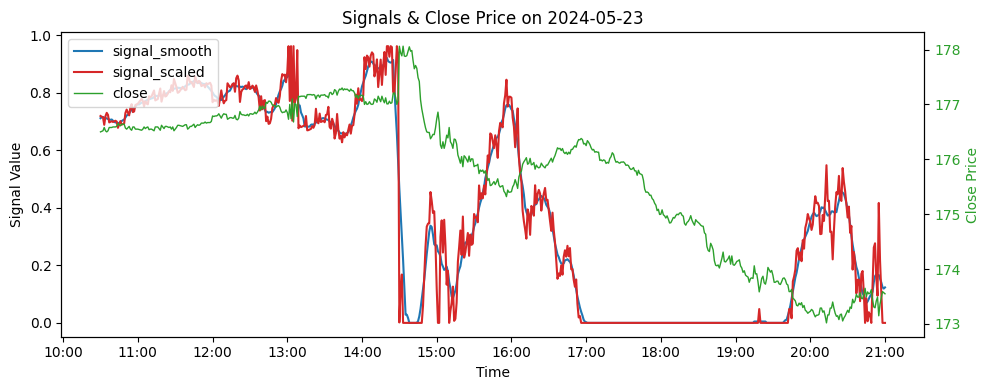

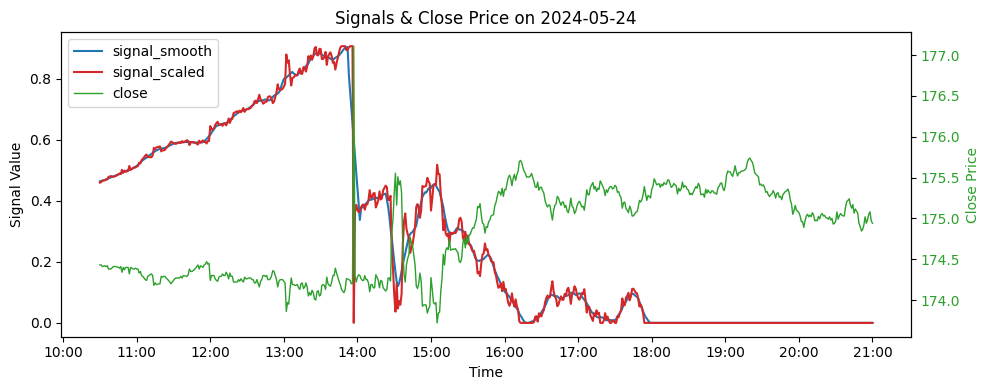

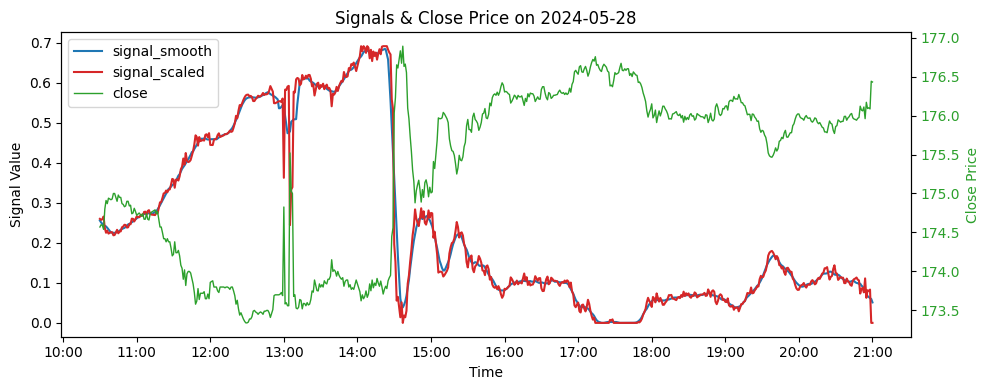

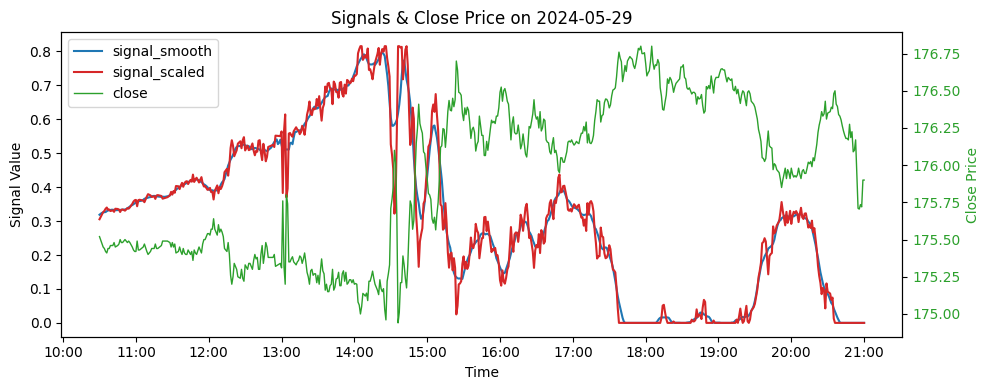

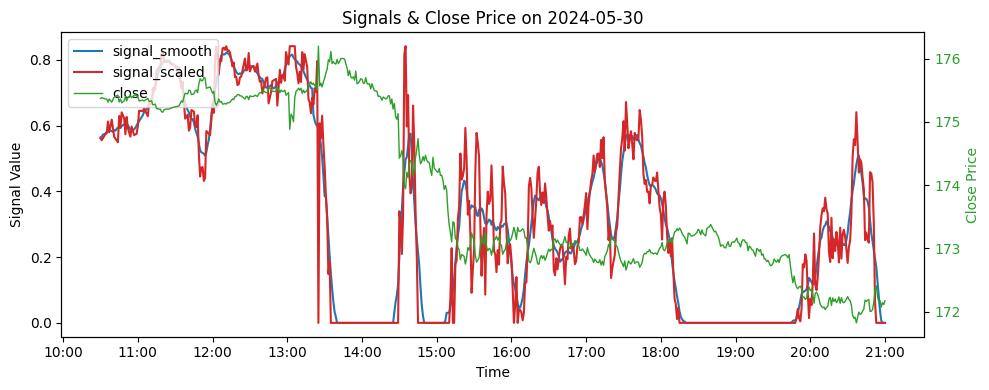

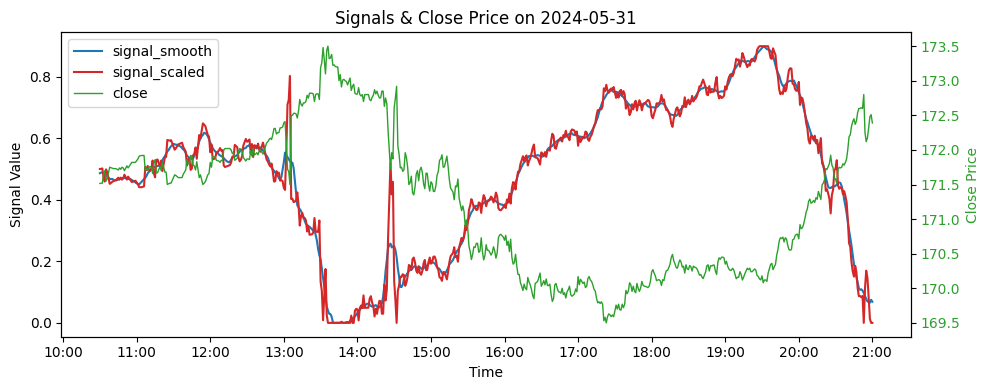

In [7]:
if date_to_check == None:
    
    # 1) Ensure the index is datetime
    df_fin.index = pd.to_datetime(df_fin.index)
    
    # 2) Filter to that month
    mask_month = df_fin.index.strftime("%Y-%m") == month_to_plot
    df_month  = df_fin.loc[mask_month]
    
    # 3) Group by calendar day
    groups = df_month.groupby(df_month.index.normalize(), sort=True)
    
    # 4) Loop over each day and make a dual-axis plot
    for day_date, df_day in groups:
        day_str = day_date.strftime("%Y-%m-%d")
        if df_day.empty:
            continue
    
        fig, ax1 = plt.subplots(figsize=(10, 4))
    
        # Plot signal_smooth & signal_scaled on the left y-axis
        ax1.plot(
            df_day.index, df_day["signal_smooth"],
            color="tab:blue", lw=1.5, label="signal_smooth"
        )
        ax1.plot(
            df_day.index, df_day["signal_scaled"],
            color="tab:red",  lw=1.5, label="signal_scaled"
        )
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Signal Value")
        ax1.tick_params(axis="y", labelcolor="black")
    
        # Plot close price on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(
            df_day.index, df_day["close"],
            color="tab:green", lw=1.0, label="close"
        )
        ax2.set_ylabel("Close Price", color="tab:green")
        ax2.tick_params(axis="y", labelcolor="tab:green")
    
        # Combine legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
    
        plt.title(f"Signals & Close Price on {day_str}")
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M"))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
